#### **Phase 3: Modeling & Evaluation Strategy**

Now that the data is processed, we enter the iterative modeling phase.

* **Model Selection:** We will use **XGBoost Regressor** as our baseline due to its ability to handle non-linear degradation and feature interactions.
* **Evaluation Metric:** While we use **MSE/RMSE** for training, our primary "North Star" metric is the **NASA Scoring Function**, which penalizes late predictions more heavily.
* **Validation Strategy:** We will perform **Leave-One-Engine-Out** or simple **Train/Validation splits** on the training data before final evaluation on the official Test sets.
* **Workflow:** We will remain in this notebook to allow for rapid plotting of "Prediction vs. Truth" curves until the error score is minimized.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import os

In [2]:
# 1. NASA Scoring Function
def compute_nasa_score(y_true, y_pred):
    """
    Computes the asymmetric NASA scoring function for RUL.
    """
    d = y_pred - y_true
    score = 0
    for diff in d:
        if diff < 0:
            score += np.exp(-diff / 13) - 1
        else:
            score += np.exp(diff / 10) - 1
    return score

In [33]:
# 1. NASA Scoring Function (Asymmetric)
def compute_nasa_score(y_true, y_pred):
    d = y_pred - y_true
    score = 0
    for diff in d:
        if diff < 0:
            score += np.exp(-diff / 13) - 1
        else:
            score += np.exp(diff / 10) - 1
    return score

#### FD001

In [ ]:

# 1. Loading Final FD001 Data
DATA_DIR = "data/final_processed"
train_df = pd.read_csv(os.path.join(DATA_DIR, "train_FD001_final.csv"))

# 2. Refined Feature Selection
# Explicitly dropping identifiers, targets, and regime labels
drop_cols = ['unit_id', 'cycle', 'RUL', 'RUL_clipped', 'time', 'regime']
features = [c for c in train_df.columns if c not in drop_cols]

X_train = train_df[features]
y_train = train_df['RUL_clipped']

# 3. Baseline XGBoost Regressor
model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=3,
    reg_alpha=10,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# {'subsample': 0.7, 'reg_alpha': 10, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

# 5. Training
print(f"Training on FD001 | Features: {len(features)}")
model.fit(X_train, y_train)

# 6. Initial Metrics
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_score = compute_nasa_score(y_train, train_preds)

print(f"FD001 Train RMSE: {train_rmse:.2f}")
print(f"FD001 Train NASA Score: {train_score:.2f}")

Training on FD001 | Features: 60
FD001 Train RMSE: 21.43
FD001 Train NASA Score: 135115.23


--- FD001 Validation ---
Final RMSE: 20.73
Final NASA Score: 789.25


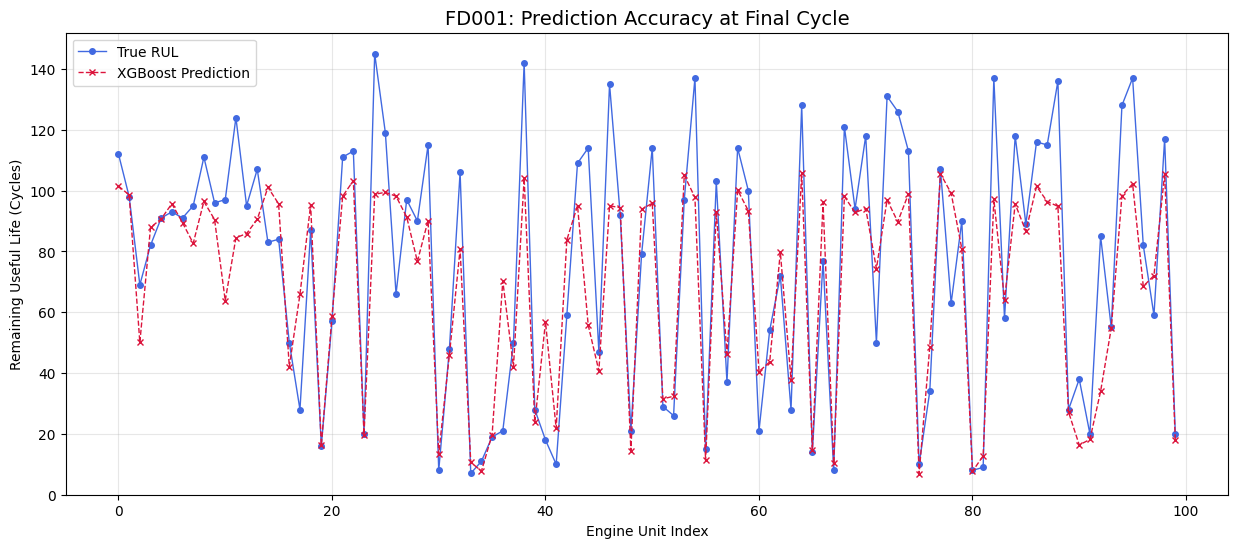

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths
FINAL_DIR = "data/final_processed"
RUL_PATH = os.path.join(FINAL_DIR, "RUL_FD001.csv") # Updated path
TEST_DATA_PATH = os.path.join(FINAL_DIR, "test_FD001_final.csv")

# 1. Load Ground Truth
# Assuming the CSV has no header and a single column of values
y_test_truth = pd.read_csv(RUL_PATH, header=None).values.flatten()

# 2. Prepare Test Features (Last cycle only)
df_test = pd.read_csv(TEST_DATA_PATH)
X_test_last = df_test.groupby('unit_id').last().reset_index()

# Ensure identifiers and targets are removed
drop_cols = ['unit_id', 'cycle', 'RUL', 'RUL_clipped', 'time', 'regime']
features = [c for c in X_test_last.columns if c not in drop_cols]
X_test_features = X_test_last[features]

# 3. Predict and Score
y_test_pred = model.predict(X_test_features)
y_test_pred = np.maximum(y_test_pred, 0) # Floor at 0

test_rmse = np.sqrt(mean_squared_error(y_test_truth, y_test_pred))
test_nasa = compute_nasa_score(y_test_truth, y_test_pred)

print(f"--- FD001 Validation ---")
print(f"Final RMSE: {test_rmse:.2f}")
print(f"Final NASA Score: {test_nasa:.2f}")

# 4. Visualization
plt.figure(figsize=(15, 6))
plt.plot(y_test_truth, label='True RUL', color='royalblue', marker='o', markersize=4, linewidth=1)
plt.plot(y_test_pred, label='XGBoost Prediction', color='crimson', marker='x', markersize=4, linewidth=1, linestyle='--')

plt.title("FD001: Prediction Accuracy at Final Cycle", fontsize=14)
plt.xlabel("Engine Unit Index")
plt.ylabel("Remaining Useful Life (Cycles)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


---
---

#### **Checks on other dataset , chupke se :**

#### FD002

In [27]:

# 1. Loading Final FD00 Data
DATA_DIR = "data/final_processed"
train_df = pd.read_csv(os.path.join(DATA_DIR, "train_FD002_final.csv"))

# 3. Refined Feature Selection
# Explicitly dropping identifiers, targets, and regime labels
drop_cols = ['unit_id', 'cycle', 'RUL', 'RUL_clipped', 'time', 'regime']
features = [c for c in train_df.columns if c not in drop_cols]

X_train = train_df[features]
y_train = train_df['RUL_clipped']

# 4. Baseline XGBoost Regressor
model = xgb.XGBRegressor(
    n_estimators=250,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    reg_alpha=10,
    reg_lambda=1,
    min_child_weight=3,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)

# model = xgb.XGBRegressor(
#     n_estimators=150,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1
# )


# 5. Training
print(f"Training on FD002 | Features: {len(features)}")
model.fit(X_train, y_train)

# 6. Initial Metrics
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_score = compute_nasa_score(y_train, train_preds)

print(f"FD002 Train RMSE: {train_rmse:.2f}")
print(f"FD002 Train NASA Score: {train_score:.2f}")

Training on FD002 | Features: 64
FD002 Train RMSE: 16.91
FD002 Train NASA Score: 489035.09


--- FD002 Validation ---
Final RMSE: 28.73
Final NASA Score: 12907.77


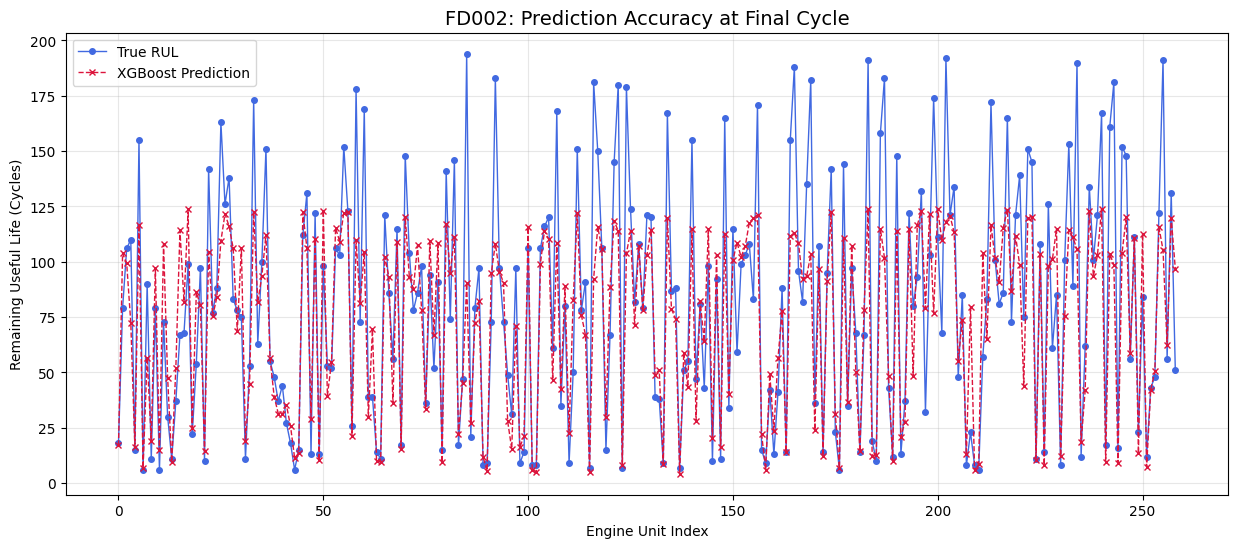

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths
FINAL_DIR = "data/final_processed"
RUL_PATH = os.path.join(FINAL_DIR, "RUL_FD002.csv") # Updated path
TEST_DATA_PATH = os.path.join(FINAL_DIR, "test_FD002_final.csv")

# 1. Load Ground Truth
# Assuming the CSV has no header and a single column of values
y_test_truth = pd.read_csv(RUL_PATH, header=None).values.flatten()

# 2. Prepare Test Features (Last cycle only)
df_test = pd.read_csv(TEST_DATA_PATH)
X_test_last = df_test.groupby('unit_id').last().reset_index()

# Ensure identifiers and targets are removed
drop_cols = ['unit_id', 'cycle', 'RUL', 'RUL_clipped', 'time', 'regime']
features = [c for c in X_test_last.columns if c not in drop_cols]
X_test_features = X_test_last[features]

# 3. Predict and Score
y_test_pred = model.predict(X_test_features)
y_test_pred = np.maximum(y_test_pred, 0) # Floor at 0

test_rmse = np.sqrt(mean_squared_error(y_test_truth, y_test_pred))
test_nasa = compute_nasa_score(y_test_truth, y_test_pred)

print(f"--- FD002 Validation ---")
print(f"Final RMSE: {test_rmse:.2f}")
print(f"Final NASA Score: {test_nasa:.2f}")

# 4. Visualization
plt.figure(figsize=(15, 6))
plt.plot(y_test_truth, label='True RUL', color='royalblue', marker='o', markersize=4, linewidth=1)
plt.plot(y_test_pred, label='XGBoost Prediction', color='crimson', marker='x', markersize=4, linewidth=1, linestyle='--')

plt.title("FD002: Prediction Accuracy at Final Cycle", fontsize=14)
plt.xlabel("Engine Unit Index")
plt.ylabel("Remaining Useful Life (Cycles)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### FD004

In [31]:

# 1. Loading Final FD004 Data
DATA_DIR = "data/final_processed"
train_df = pd.read_csv(os.path.join(DATA_DIR, "train_FD004_final.csv"))

# 3. Refined Feature Selection
# Explicitly dropping identifiers, targets, and regime labels
drop_cols = ['unit_id', 'cycle', 'RUL', 'RUL_clipped', 'time', 'regime']
features = [c for c in train_df.columns if c not in drop_cols]

X_train = train_df[features]
y_train = train_df['RUL_clipped']

# 4. Baseline XGBoost Regressor
model = xgb.XGBRegressor(
    n_estimators=250,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    reg_alpha=10,
    reg_lambda=1,
    min_child_weight=3,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)

# model = xgb.XGBRegressor(
#     n_estimators=150,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1
# )


# 5. Training
print(f"Training on FD004 | Features: {len(features)}")
model.fit(X_train, y_train)

# 6. Initial Metrics
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_score = compute_nasa_score(y_train, train_preds)

print(f"FD004 Train RMSE: {train_rmse:.2f}")
print(f"FD004 Train NASA Score: {train_score:.2f}")

Training on FD004 | Features: 48
FD004 Train RMSE: 15.85
FD004 Train NASA Score: 505251.98


--- FD004 Validation ---
Final RMSE: 30.90
Final NASA Score: 8374.88


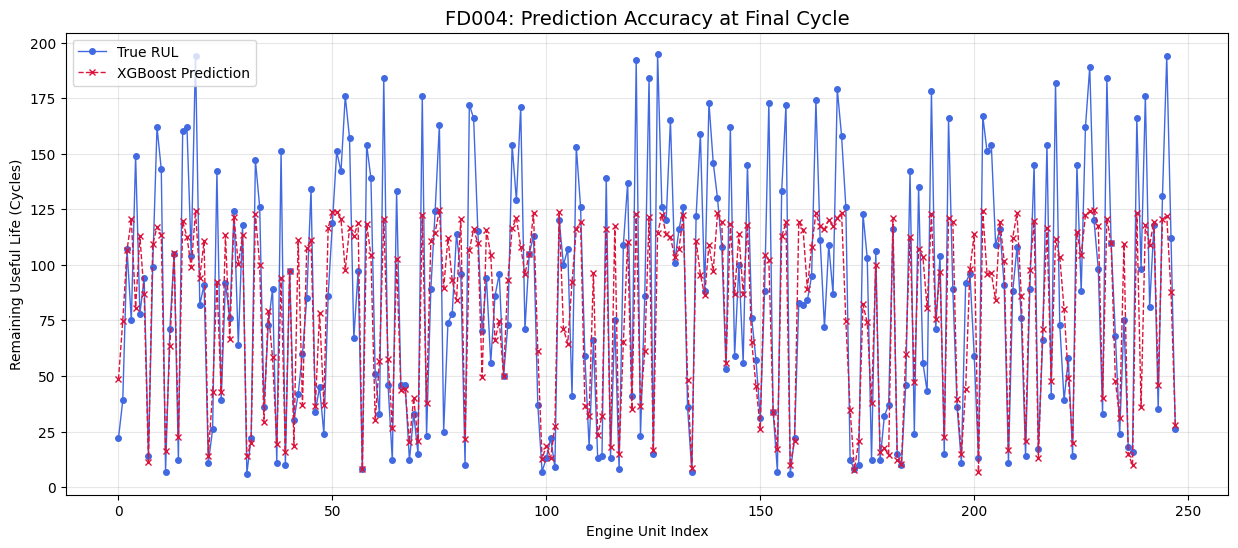

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths
FINAL_DIR = "data/final_processed"
RUL_PATH = os.path.join(FINAL_DIR, "RUL_FD004.csv") # Updated path
TEST_DATA_PATH = os.path.join(FINAL_DIR, "test_FD004_final.csv")

# 1. Load Ground Truth
# Assuming the CSV has no header and a single column of values
y_test_truth = pd.read_csv(RUL_PATH, header=None).values.flatten()

# 2. Prepare Test Features (Last cycle only)
df_test = pd.read_csv(TEST_DATA_PATH)
X_test_last = df_test.groupby('unit_id').last().reset_index()

# Ensure identifiers and targets are removed
drop_cols = ['unit_id', 'cycle', 'RUL', 'RUL_clipped', 'time', 'regime']
features = [c for c in X_test_last.columns if c not in drop_cols]
X_test_features = X_test_last[features]

# 3. Predict and Score
y_test_pred = model.predict(X_test_features)
y_test_pred = np.maximum(y_test_pred, 0) # Floor at 0

test_rmse = np.sqrt(mean_squared_error(y_test_truth, y_test_pred))
test_nasa = compute_nasa_score(y_test_truth, y_test_pred)

print(f"--- FD004 Validation ---")
print(f"Final RMSE: {test_rmse:.2f}")
print(f"Final NASA Score: {test_nasa:.2f}")

# 4. Visualization
plt.figure(figsize=(15, 6))
plt.plot(y_test_truth, label='True RUL', color='royalblue', marker='o', markersize=4, linewidth=1)
plt.plot(y_test_pred, label='XGBoost Prediction', color='crimson', marker='x', markersize=4, linewidth=1, linestyle='--')

plt.title("FD004: Prediction Accuracy at Final Cycle", fontsize=14)
plt.xlabel("Engine Unit Index")
plt.ylabel("Remaining Useful Life (Cycles)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### FD003

In [ ]:

# 1. Loading Final FD003  Data
DATA_DIR = "data/final_processed"
train_df = pd.read_csv(os.path.join(DATA_DIR, "train_FD003_final.csv"))

# 3. Refined Feature Selection
# Explicitly dropping identifiers, targets, and regime labels
drop_cols = ['unit_id', 'cycle', 'RUL', 'RUL_clipped', 'time', 'regime']
features = [c for c in train_df.columns if c not in drop_cols]

X_train = train_df[features]
y_train = train_df['RUL_clipped']

# 4. Baseline XGBoost Regressor
model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=3,
    reg_alpha=10,
    subsample=0.7,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# model = xgb.XGBRegressor(
#     n_estimators=150,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1
# )


# 5. Training
print(f"Training on FD003 | Features: {len(features)}")
model.fit(X_train, y_train)

# 6. Initial Metrics
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_score = compute_nasa_score(y_train, train_preds)

print(f"FD003 Train RMSE: {train_rmse:.2f}")
print(f"FD003 Train NASA Score: {train_score:.2f}")

Training on FD003 | Features: 60
FD003 Train RMSE: 20.49
FD003 Train NASA Score: 136814.81


--- FD001 Validation ---
Final RMSE: 21.38
Final NASA Score: 1016.14


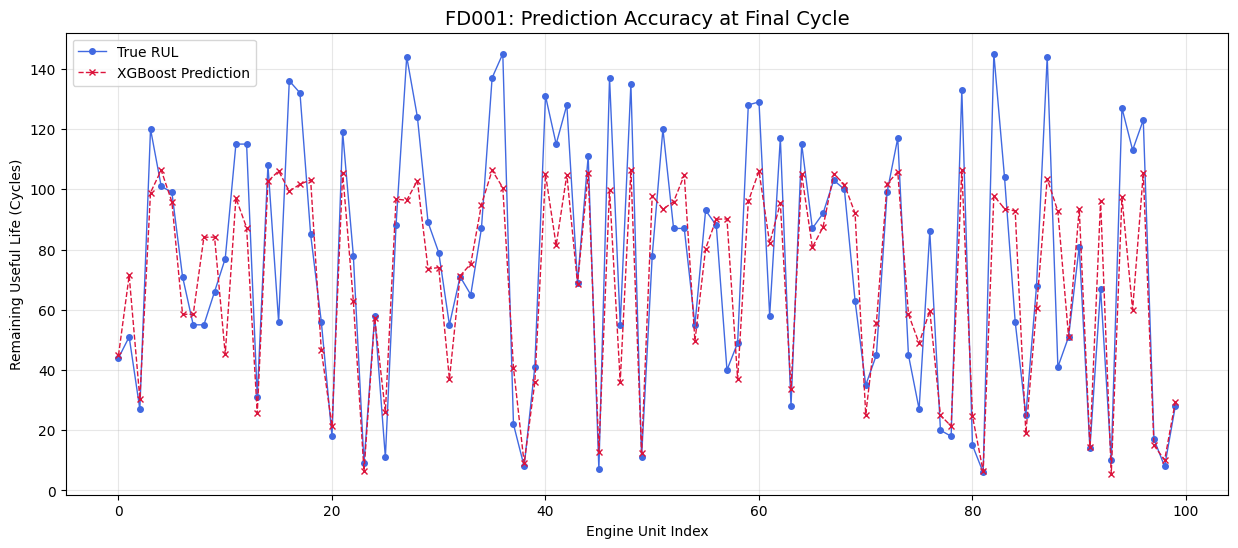

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths
FINAL_DIR = "data/final_processed"
RUL_PATH = os.path.join(FINAL_DIR, "RUL_FD003.csv") # Updated path
TEST_DATA_PATH = os.path.join(FINAL_DIR, "test_FD003_final.csv")

# 1. Load Ground Truth
# Assuming the CSV has no header and a single column of values
y_test_truth = pd.read_csv(RUL_PATH, header=None).values.flatten()

# 2. Prepare Test Features (Last cycle only)
df_test = pd.read_csv(TEST_DATA_PATH)
X_test_last = df_test.groupby('unit_id').last().reset_index()

# Ensure identifiers and targets are removed
drop_cols = ['unit_id', 'cycle', 'RUL', 'RUL_clipped', 'time', 'regime']
features = [c for c in X_test_last.columns if c not in drop_cols]
X_test_features = X_test_last[features]

# 3. Predict and Score
y_test_pred = model.predict(X_test_features)
y_test_pred = np.maximum(y_test_pred, 0) # Floor at 0

test_rmse = np.sqrt(mean_squared_error(y_test_truth, y_test_pred))
test_nasa = compute_nasa_score(y_test_truth, y_test_pred)

print(f"--- FD001 Validation ---")
print(f"Final RMSE: {test_rmse:.2f}")
print(f"Final NASA Score: {test_nasa:.2f}")

# 4. Visualization
plt.figure(figsize=(15, 6))
plt.plot(y_test_truth, label='True RUL', color='royalblue', marker='o', markersize=4, linewidth=1)
plt.plot(y_test_pred, label='XGBoost Prediction', color='crimson', marker='x', markersize=4, linewidth=1, linestyle='--')

plt.title("FD001: Prediction Accuracy at Final Cycle", fontsize=14)
plt.xlabel("Engine Unit Index")
plt.ylabel("Remaining Useful Life (Cycles)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Hyperparameter Tuning (Randomized Search)

We apply **RandomizedSearchCV** to optimize the XGBoost architecture, specifically targeting the high variance seen in FD002. , lets see on FD001

* **Objective:** Minimize the NASA Scoring Function (via a custom scorer) rather than just MSE.
* **Key Parameters:**
    * `max_depth`: Lowering this restricts model complexity to prevent overfitting to regime noise.
    * `min_child_weight`: Increasing this forces the model to be more conservative in creating new branches.
    * `reg_alpha` / `reg_lambda`: L1/L2 regularization to handle the multi-regime volatility of FD002.

#### `RandomizedCV` on FD001 first , after that might think of others

In [19]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
import os

# --- Configuration ---
DATASET = "FD001"
DATA_DIR = "data/final_processed"

# 1. Load Data
print(f"Loading {DATASET} for Tuning...")
train_df = pd.read_csv(os.path.join(DATA_DIR, f"train_{DATASET}_final.csv"))

# Drop non-features
drop_cols = ['unit_id', 'cycle', 'RUL', 'RUL_clipped', 'time', 'regime']
features = [c for c in train_df.columns if c not in drop_cols]
X = train_df[features]
y = train_df['RUL_clipped']

# 2. Validation Split Strategy (Last 20% of engines)
unique_units = train_df['unit_id'].unique()
val_units = unique_units[int(len(unique_units) * 0.8):] 
split_index = [-1 if uid not in val_units else 0 for uid in train_df['unit_id']]
ps = PredefinedSplit(test_fold=split_index)

# 3. Define NASA Scorer
def nasa_score_func(y_true, y_pred):
    d = y_pred - y_true
    score = 0
    for diff in d:
        if diff < 0: score += np.exp(-diff / 13) - 1
        else:        score += np.exp(diff / 10) - 1
    return score

# Negate score because sklearn maximizes, but we want to minimize NASA score
nasa_scorer = make_scorer(nasa_score_func, greater_is_better=False)

# 4. Parameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0.1, 1, 10]         # L1 Reg (Critical for FD002)
}

# 5. Run Search (Safe Mode)
print("Starting Randomized Search (Sequential Mode)...")

# CRITICAL FIX: n_jobs=-1 here lets XGBoost use all cores for the SINGLE model being trained
xgb_reg = xgb.XGBRegressor(random_state=42, n_jobs=-1) 

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=15,           # Reduced slightly to speed up debugging
    scoring=nasa_scorer, 
    cv=ps, 
    verbose=1,
    random_state=42,
    n_jobs=1             
)

random_search.fit(X, y)

# 6. Report Best Results
print("\n--- Tuning Complete ---")
# Remember to negate the score back to positive
print(f"Best NASA Score (Validation): {-random_search.best_score_:.2f}")
print("Best Parameters:")
print(random_search.best_params_)

Loading FD001 for Tuning...
Starting Randomized Search (Sequential Mode)...
Fitting 1 folds for each of 15 candidates, totalling 15 fits

--- Tuning Complete ---
Best NASA Score (Validation): 38034.53
Best Parameters:
{'subsample': 0.7, 'reg_alpha': 10, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


#### `RCV` on FD002

In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
import os

# --- Configuration ---
DATASET = "FD002"
DATA_DIR = "data/final_processed"

# 1. Load Data
print(f"Loading {DATASET} for Tuning...")
train_df = pd.read_csv(os.path.join(DATA_DIR, f"train_{DATASET}_final.csv"))

# Drop non-features
drop_cols = ['unit_id', 'cycle', 'RUL', 'RUL_clipped', 'time', 'regime']
features = [c for c in train_df.columns if c not in drop_cols]
X = train_df[features]
y = train_df['RUL_clipped']

# 2. Validation Split Strategy (Last 20% of engines)
unique_units = train_df['unit_id'].unique()
val_units = unique_units[int(len(unique_units) * 0.8):] 
split_index = [-1 if uid not in val_units else 0 for uid in train_df['unit_id']]
ps = PredefinedSplit(test_fold=split_index)

# 3. Define NASA Scorer
def nasa_score_func(y_true, y_pred):
    d = y_pred - y_true
    score = 0
    for diff in d:
        if diff < 0: score += np.exp(-diff / 13) - 1
        else:        score += np.exp(diff / 10) - 1
    return score

# Negate score because sklearn maximizes, but we want to minimize NASA score
nasa_scorer = make_scorer(nasa_score_func, greater_is_better=False)

# 4. Parameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0.1, 1, 10]         # L1 Reg (Critical for FD002)
}

# 5. Run Search (Safe Mode)
print("Starting Randomized Search (Sequential Mode)...")

# CRITICAL FIX: n_jobs=-1 here lets XGBoost use all cores for the SINGLE model being trained
xgb_reg = xgb.XGBRegressor(random_state=42, n_jobs=-1) 

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=15,           # Reduced slightly to speed up debugging
    scoring=nasa_scorer, 
    cv=ps, 
    verbose=1,
    random_state=42,
    n_jobs=1             
)

random_search.fit(X, y)

# 6. Report Best Results
print("\n--- Tuning Complete ---")
# Remember to negate the score back to positive
print(f"Best NASA Score (Validation): {-random_search.best_score_:.2f}")
print("Best Parameters:")
print(random_search.best_params_)

Loading FD002 for Tuning...
Starting Randomized Search (Sequential Mode)...
Fitting 1 folds for each of 15 candidates, totalling 15 fits

--- Tuning Complete ---
Best NASA Score (Validation): 89355.79
Best Parameters:
{'subsample': 0.8, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


--- Optimization Search for FD002 Target ---
   👉 Clip 100: RMSE=34.59 | NASA=28459
   👉 Clip 110: RMSE=31.67 | NASA=19091
   👉 Clip 120: RMSE=29.53 | NASA=14202
   👉 Clip 130: RMSE=28.10 | NASA=11241
   👉 Clip 140: RMSE=27.28 | NASA=9761
   👉 Clip 150: RMSE=26.89 | NASA=9448


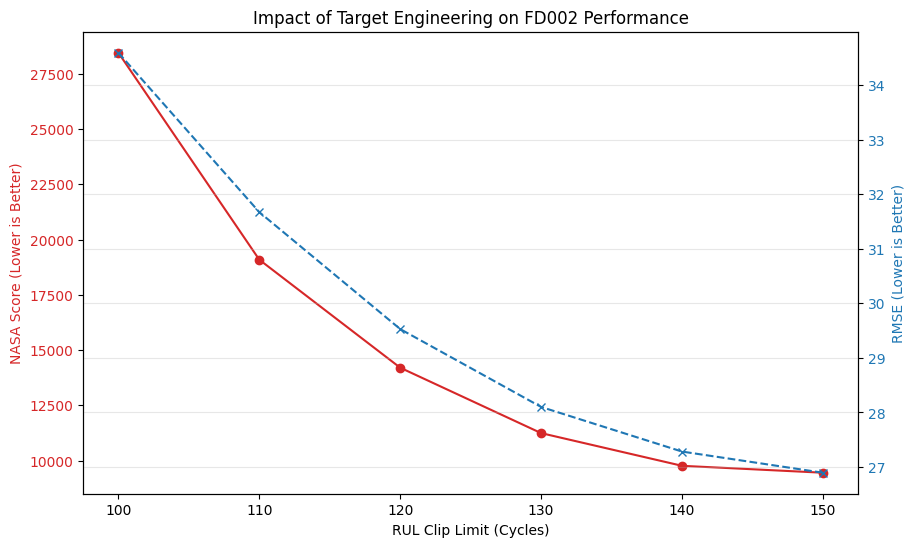


🏆 Optimal Clip Limit for FD002: 150.0


In [34]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error

# Configuration
DATASET = "FD002"
CLIP_CANDIDATES = [100, 110, 120, 130, 140, 150]
DATA_DIR = "data/final_processed"

# 1. Load Data (We need the original RUL to re-clip it)
# Note: We need to reconstruct the unclipped RUL for training since we saved the clipped version.
# Fortunately, we can just reload the engineered features which have the raw 'RUL'.
raw_train_path = f"data/engineered_features/train_{DATASET}_engineered.csv"
if not os.path.exists(raw_train_path):
    print("⚠️ Please ensure the 'engineered_features' folder exists from Phase 2.")
else:
    df_raw = pd.read_csv(raw_train_path)
    
    # Prepare Validation Data (Test Set)
    test_df = pd.read_csv(os.path.join(DATA_DIR, f"test_{DATASET}_final.csv"))
    y_test_truth = pd.read_csv(os.path.join(DATA_DIR, f"RUL_{DATASET}.csv"), header=None).values.flatten()
    
    # Feature Selection (Exclude non-features)
    drop_cols = ['unit_id', 'cycle', 'RUL', 'RUL_clipped', 'time', 'regime']
    features = [c for c in df_raw.columns if c not in drop_cols]
    
    results = []

    print(f"--- Optimization Search for {DATASET} Target ---")
    
    for clip_val in CLIP_CANDIDATES:
        # A. Create Custom Target
        y_train_custom = df_raw['RUL'].clip(upper=clip_val)
        
        # B. Train Model (Using the refined params we found earlier)
        model = xgb.XGBRegressor(
            n_estimators=200, 
            learning_rate=0.03, 
            max_depth=4, 
            subsample=0.8,
            colsample_bytree=0.7,
            reg_alpha=10,
            n_jobs=-1,
            random_state=42
        )
        
        model.fit(df_raw[features], y_train_custom)
        
        # C. Evaluate
        X_test_last = test_df.groupby('unit_id').last().reset_index()[features]
        y_pred = np.maximum(model.predict(X_test_last), 0)
        
        # Score
        rmse = np.sqrt(mean_squared_error(y_test_truth, y_pred))
        
        # Compute NASA Score
        score = 0
        d = y_pred - y_test_truth
        for diff in d:
            if diff < 0: score += np.exp(-diff/13) - 1
            else:        score += np.exp(diff/10) - 1
            
        results.append({'Clip': clip_val, 'RMSE': rmse, 'NASA': score})
        print(f"   👉 Clip {clip_val}: RMSE={rmse:.2f} | NASA={score:.0f}")

    # Visualization
    res_df = pd.DataFrame(results)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    color = 'tab:red'
    ax1.set_xlabel('RUL Clip Limit (Cycles)')
    ax1.set_ylabel('NASA Score (Lower is Better)', color=color)
    ax1.plot(res_df['Clip'], res_df['NASA'], color=color, marker='o', label='NASA Score')
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx() 
    color = 'tab:blue'
    ax2.set_ylabel('RMSE (Lower is Better)', color=color)
    ax2.plot(res_df['Clip'], res_df['RMSE'], color=color, marker='x', linestyle='--', label='RMSE')
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title(f"Impact of Target Engineering on {DATASET} Performance")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Identify Winner
    best_clip = res_df.loc[res_df['NASA'].idxmin()]['Clip']
    print(f"\n🏆 Optimal Clip Limit for {DATASET}: {best_clip}")

In [35]:
import pandas as pd
import os

# --- Configuration for the New Experiment ---
INPUT_DIR = "data/engineered_features"
OUTPUT_DIR = "data/final_processed_v2" # Version 2 for the 150-clip experiment
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Dataset-specific clipping strategy
CLIP_STRATEGY = {
    'FD001': 125,
    'FD002': 150, # Increased for better early degradation capture
    'FD003': 125,
    'FD004': 150  # Increased for better early degradation capture
}

def apply_target_engineering(df, dataset_id):
    if 'RUL' in df.columns:
        clip_limit = CLIP_STRATEGY.get(dataset_id, 125)
        df['RUL_clipped'] = df['RUL'].clip(upper=clip_limit)
        print(f"   -> {dataset_id}: Target clipped at {clip_limit}")
    return df

# --- Processing Loop ---
for ds in ['FD002', 'FD004']: # Focus only on the datasets you are fixing
    train_file = os.path.join(INPUT_DIR, f"train_{ds}_engineered.csv")
    
    if os.path.exists(train_file):
        df = pd.read_csv(train_file)
        df = apply_target_engineering(df, ds)
        
        save_path = os.path.join(OUTPUT_DIR, f"train_{ds}_final.csv")
        df.to_csv(save_path, index=False)
        print(f"✅ Saved v2 Data: {save_path}")

   -> FD002: Target clipped at 150
✅ Saved v2 Data: data/final_processed_v2\train_FD002_final.csv
   -> FD004: Target clipped at 150
✅ Saved v2 Data: data/final_processed_v2\train_FD004_final.csv
